### Face detection with `retinaface` and `decord`

In [1]:
from fastai.vision import *
import cv2 as cv

In [2]:
data_path = Path("/home/ubuntu/data/")

In [3]:
video_path = data_path/"dfdc_train_part_49"

In [4]:
metadata = get_files("/home/ubuntu/data/dfdc_train_part_49/", extensions=['.json'])

In [5]:
video_files = get_files("/home/ubuntu/data/dfdc_train_part_49/", extensions=['.mp4'])

In [6]:
def read_metadata(fn):
    metadf = pd.read_json(fn).T.reset_index()
    metadf.columns = ['fname','label','split','original']
    return metadf 

In [7]:
metadf = read_metadata(metadata[0])

In [8]:
metadf.head()

fname label  split        original
0  dwwytkheyx.mp4  FAKE  train  nlcqykqsdp.mp4
1  bdsxxaamze.mp4  FAKE  train  xzmplldajk.mp4
2  tfceaqvefa.mp4  FAKE  train  zkksmnscsf.mp4
3  lurozpmsqd.mp4  FAKE  train  urbulrzowx.mp4
4  jvlvkijuwa.mp4  FAKE  train  wvnjcwevzo.mp4

In [9]:
metadf.groupby("label")[["fname",'original']].count()

fname  original
label                 
FAKE    2619      2619
REAL     515         0

### configs

In [10]:
device = torch.device(0)
retinaface_stats = tensor([123,117,104]).to(device) # RGB stats for retina face

### read video frames

In [11]:
# VANILLA OPENCV
def frame_img_generator(path, freq=None):
    "frame image generator for a given video file"
    vidcap = cv.VideoCapture(str(path))
    n_frames = 0
    while True:
        success = vidcap.grab()
        if not success: 
            vidcap.release()
            break   
            
        if (freq is None) or (n_frames % freq == 0):
            _, image = vidcap.retrieve()
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            yield {"frame_no":n_frames, "frame_array":image}    
            
        n_frames += 1
        
    vidcap.release()
    

In [12]:
def get_video_batch1(fname, freq=10, sz=640, stats=None):
    "get batch tensor for inference, original for cropping and H,W of video"
    # read frame dicts
    orig_frames = frame_img_generator(fname, freq)
    # extract frame arrays
    orig_frames = [o['frame_array'] for o in orig_frames]
    # get original frame size
    H,W = orig_frames[0].shape[:-1]
    # resize for model
    resized_frames = array([cv.resize(o,(sz,sz)) for o in orig_frames])
    # convert to torch tensor
    t = (torch.from_numpy(resized_frames).to(torch.float32)).permute(0,3,1,2).to(device)
    # mean substraction
    if stats is not None: t -= stats[...,None,None]
    return (t, (H, W))

In [13]:
%%timeit
t1, (H, W) = get_video_batch1(video_files[0], stats=retinaface_stats)

561 ms ± 9.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
def get_video_batch2(fname, freq=10, sz=640, stats=None):
    "get batch tensor for inference, original for cropping and H,W of video"
    # read frame dicts
    orig_frames = frame_img_generator(fname, freq)
    # extract frame arrays
    orig_frames = array([o['frame_array'] for o in orig_frames])
    # get original frame size
    H,W = orig_frames[0].shape[:-1]
    # convert to torch tensor
    t = (torch.from_numpy(orig_frames).to(torch.float32)).permute(0,3,1,2).to(device)
    t = F.interpolate(t, (sz,sz))
    # mean substraction
    if stats is not None: t -= stats[...,None,None]
    return (t, (H, W))

In [15]:
%%timeit
t2, (H, W) = get_video_batch2(video_files[0], stats=retinaface_stats)

666 ms ± 19.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
t1, (H, W) = get_video_batch1(video_files[0], stats=retinaface_stats)
t2, (H, W) = get_video_batch2(video_files[0], stats=retinaface_stats)
torch.mean(torch.isclose(t1, t2, atol=1).float())

tensor(0.7325, device='cuda:0')

### Decord

In [2]:
from decord import VideoReader
from decord import cpu, gpu
from decord.bridge import set_bridge
set_bridge('torch')

In [18]:
def get_decord_video_batch_gpu(fname, freq=10, sz=640, stats=None):
    "get batch tensor for inference, original for cropping and H,W of video"
    video = VideoReader(str(fname), ctx=gpu())
    data = video.get_batch(range(0, len(video), freq))
    H,W = data.shape[2:]
    t = F.interpolate(data.to(torch.float32), (sz,sz))
    if stats is not None: t -= stats[...,None,None]
    return (t, (H, W))

In [19]:
%%timeit
t3, (H, W) = get_decord_video_batch_gpu(video_files[0], stats=retinaface_stats)

306 ms ± 3.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
def get_decord_video_batch_cpu(fname, freq=10, sz=640, stats=None):
    "get batch tensor for inference, original for cropping and H,W of video"
    video = VideoReader(str(fname), ctx=cpu())
    data = video.get_batch(range(0, len(video), freq)).to(device)
    H,W = data.shape[2:]
    t = F.interpolate(data.to(torch.float32), (sz,sz))
    if stats is not None: t -= stats[...,None,None]
    return (t, (H, W))

In [21]:
%%timeit
t3, (H, W) = get_decord_video_batch_cpu(video_files[0], stats=retinaface_stats)

492 ms ± 6.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Retinaface

In [22]:
sys.path.insert(0,"./Pytorch_Retinaface/")

In [23]:
import os
import torch
import torch.backends.cudnn as cudnn
import numpy as np
from data import cfg_mnet, cfg_re50
from layers.functions.prior_box import PriorBox
from utils.nms.py_cpu_nms import py_cpu_nms
import cv2
from models.retinaface import RetinaFace
from utils.box_utils import decode, decode_landm
import time

In [24]:
def check_keys(model, pretrained_state_dict):
    ckpt_keys = set(pretrained_state_dict.keys())
    model_keys = set(model.state_dict().keys())
    used_pretrained_keys = model_keys & ckpt_keys
    unused_pretrained_keys = ckpt_keys - model_keys
    missing_keys = model_keys - ckpt_keys
    print('Missing keys:{}'.format(len(missing_keys)))
    print('Unused checkpoint keys:{}'.format(len(unused_pretrained_keys)))
    print('Used keys:{}'.format(len(used_pretrained_keys)))
    assert len(used_pretrained_keys) > 0, 'load NONE from pretrained checkpoint'
    return True


def remove_prefix(state_dict, prefix):
    ''' Old style model is stored with all names of parameters sharing common prefix 'module.' '''
    print('remove prefix \'{}\''.format(prefix))
    f = lambda x: x.split(prefix, 1)[-1] if x.startswith(prefix) else x
    return {f(key): value for key, value in state_dict.items()}


def load_model(model, pretrained_path, load_to_cpu):
    print('Loading pretrained model from {}'.format(pretrained_path))
    if load_to_cpu:
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage)
    else:
        device = torch.cuda.current_device()
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage.cuda(device))
    if "state_dict" in pretrained_dict.keys():
        pretrained_dict = remove_prefix(pretrained_dict['state_dict'], 'module.')
    else:
        pretrained_dict = remove_prefix(pretrained_dict, 'module.')
    check_keys(model, pretrained_dict)
    model.load_state_dict(pretrained_dict, strict=False)
    return model

In [25]:
cfg_re50['image_size'], cfg_mnet['image_size']

(840, 640)

In [26]:
cudnn.benchmark = True # keep input size constant for better runtime
device = torch.device("cuda")

In [27]:
def get_model(modelname="mobilenet"):
    torch.set_grad_enabled(False)
    cfg = None
    cfg_mnet['pretrain'] = False
    cfg_re50['pretrain'] = False
    
    if modelname == "mobilenet":
        cfg = cfg_mnet
        pretrained_path = "/home/ubuntu/git/dfdc/Pytorch_Retinaface/weights/mobilenet0.25_Final.pth"
    else:
        cfg = cfg_re50
        pretrained_path = "/home/ubuntu/git/dfdc/Pytorch_Retinaface/weights/Resnet50_Final.pth"
    
    # net and model
    net = RetinaFace(cfg=cfg, phase='test')
    net = load_model(net, pretrained_path, False)
    net.eval().to(device)
    return net

In [28]:
resize = 1
scale_rate = 1

sz = 640
im_height, im_width = sz, sz 
scale = torch.Tensor([sz, sz, sz, sz])
scale = scale.to(device)


confidence_threshold = 0.5
top_k = 5
nms_threshold = 0.5
keep_top_k = 5




def predict(model:torch.nn.Module, t:tensor, sz:int, cfg):
    "get prediction for a batch t by model with image sz"
    locs, confs, landmss = torch.Tensor([]), torch.Tensor([]), torch.Tensor([])
    locs = locs.to(device)
    confs = confs.to(device)
    landmss = landmss.to(device)
    
    # forward pass
    locs_, confs_, landmss_ = model(t)  
    locs = torch.cat((locs, locs_), 0)
    confs = torch.cat((confs, confs_), 0)
    landmss = torch.cat((landmss, landmss_), 0)
    


    result = []
    priorbox = PriorBox(cfg, image_size=(im_height, im_width))
    priors = priorbox.forward()
    priors = priors.to(device)
    prior_data = priors.data
    for idx in range(t.size(0)):
        loc = locs[idx]
        conf = confs[idx]
        landms = landmss[idx]

        boxes = decode(loc.data.squeeze(0), prior_data, cfg['variance'])
        boxes = boxes * scale / resize

        boxes = boxes.cpu().numpy()
        scores = conf.squeeze(0).data.cpu().numpy()[:, 1]
        landms = decode_landm(landms.data.squeeze(0), prior_data, cfg['variance'])
        scale1 = torch.Tensor([t.shape[3], t.shape[2], t.shape[3], t.shape[2],
                            t.shape[3], t.shape[2], t.shape[3], t.shape[2],
                            t.shape[3], t.shape[2]])
        scale1 = scale1.to(device)
        landms = landms * scale1 / resize
        landms = landms.cpu().numpy()

        # ignore low scores
        inds = np.where(scores > confidence_threshold)[0]
        boxes = boxes[inds]
        landms = landms[inds]
        scores = scores[inds]

        # keep top-K before NMS
        order = scores.argsort()[::-1][:top_k]
        boxes = boxes[order]
        landms = landms[order]
        scores = scores[order]

        # do NMS
        dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
        keep = py_cpu_nms(dets, nms_threshold)

        # keep = nms(dets, args.nms_threshold,force_cpu=args.cpu)
        dets = dets[keep, :]
        landms = landms[keep]

        # keep top-K faster NMS
        dets = dets[:keep_top_k, :]
        landms = landms[:keep_top_k, :]

    #     dets = np.concatenate((dets, landms), axis=1)
    #     dets = np.concatenate((dets, landms), axis=1)
        result.append(dets[:,:-1])


    for idx in range(len(result)):
        result[idx][:, :4]=result[idx][:, :4]/scale_rate
#         result[idx][:, 5:]=result[idx][:, 5:]/scale_rate
    
    return result

In [29]:
%%time
model = get_model("mobilenet")

Loading pretrained model from /home/ubuntu/git/dfdc/Pytorch_Retinaface/weights/mobilenet0.25_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:300
CPU times: user 80 ms, sys: 0 ns, total: 80 ms
Wall time: 94.4 ms


In [69]:
def get_decord_video_batch_cpu(fname, freq=10, sz=640, stats=None):
    "get batch tensor for inference, original for cropping and H,W of video"
    video = VideoReader(str(fname), ctx=cpu())
    len_video = len(video)
    data = video.get_batch(range(0, len_video, freq)).to(device)
    H,W = data.shape[2:]
    t = F.interpolate(data.to(torch.float32), (sz,sz))
    if stats is not None: t -= stats[...,None,None]
    return (t, len_video, (H, W))

In [70]:
def convert_bboxes(bboxes, H, W, sz):
    "rescale to original image sz"
    res = []
    for bb in bboxes:
        h_scale, w_scale = H/sz, W/sz
        orig_bboxes = (bb*array([w_scale, h_scale, w_scale, h_scale])[None, ...]).astype(int)
        res.append(orig_bboxes.tolist())
    return res

In [101]:
from tqdm import tqdm

def detect_faces_in_videos(fnames, freq=10, sz=640):
    "detect faces in videos given by fnames with frame freq and image sz"
    res = []
    for fname in tqdm(fnames):
        # get video batch
        t, len_video, (H,W) = get_decord_video_batch_cpu(fname, freq=freq, sz=sz, stats=retinaface_stats)

        # predict face bboxes
        bboxes = predict(model, t, sz, cfg_mnet)
        orig_bboxes = convert_bboxes(bboxes, H, W, sz)

        # generate structured output
        video_res = {}
        video_res["fname"] = fname.name
        video_res["size"] = (H, W)
        video_res["face_detections"] = [{"frame_no":frame_no, "detections":detections}
                                for frame_no, detections in zip(range(0,len_video,freq), orig_bboxes)]
        video_res["n_frames"] = t.shape[0]
        video_res["sample_freq"] = freq
        video_res["len_video"] = len_video
        res.append(video_res)
        
    return pd.DataFrame(res)

In [170]:
df = detect_faces_in_videos(video_files)

100%|██████████| 3134/3134 [45:56<00:00,  1.14it/s]


### Visualize

In [172]:
df.to_csv(data_path/'dfdc_faces/part_49_retina_detections.csv', index=False)

In [181]:
i = np.random.choice(400)
fname = df.iloc[i]['fname']
face_detections = df.iloc[i]['face_detections']
freq = df.iloc[i]['sample_freq']
len_video = df.iloc[i]['len_video']
bboxes = [o['detections'] for o in face_detections]

In [182]:
video_fname = str(video_files[i].parent/fname)
video = VideoReader(video_fname, ctx=cpu())
data = video.get_batch(range(0, len(video), freq))

In [183]:
nframes = data.shape[0]; print(f"total frames: {nframes}")

total frames: 30


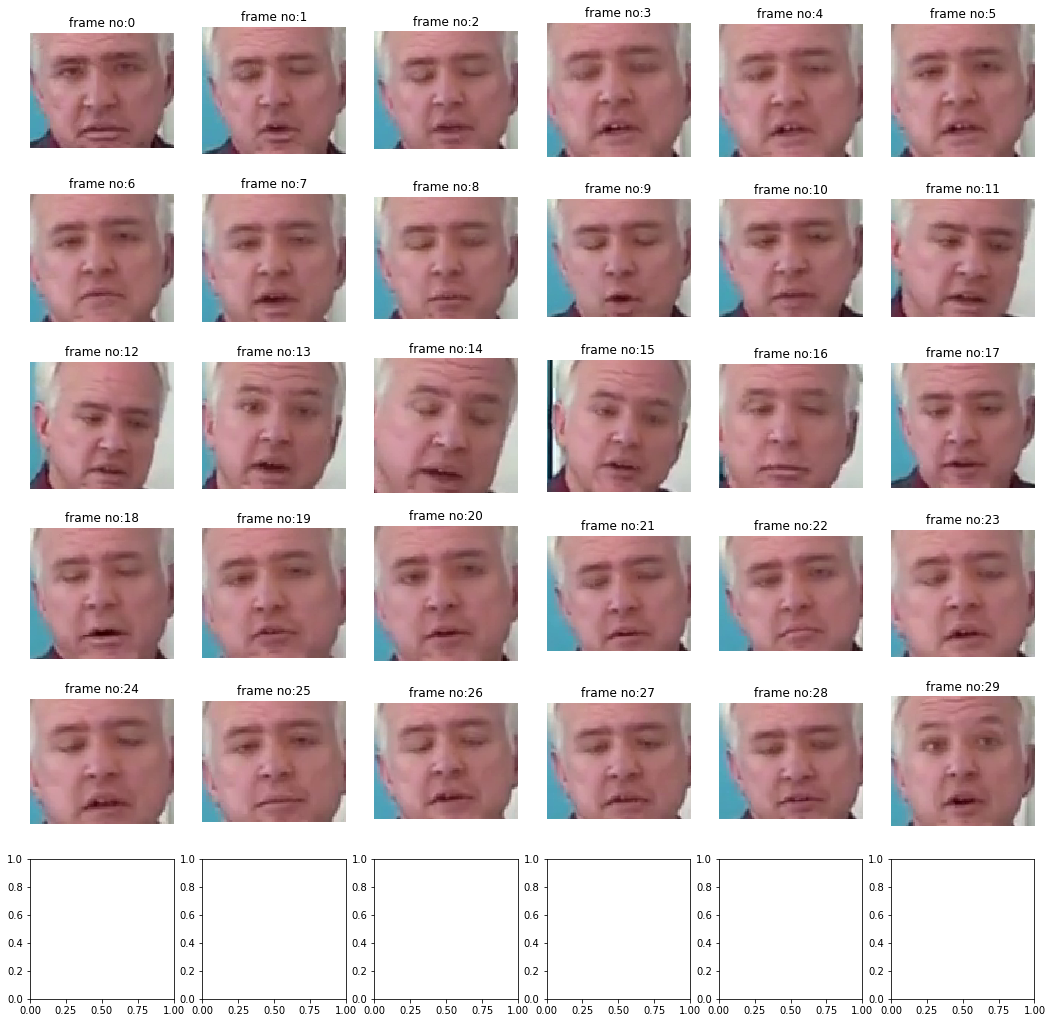

In [184]:
n = int(np.ceil(np.sqrt(nframes)))
axes = subplots(n,n, figsize=(3*n,3*n)).flatten()
for idx, (ax, _data, _bb) in enumerate(zip(axes, data, bboxes)):
    try:
        left, top, right, bottom = _bb[0] # pick first detection
        img = Image(_data[:, top:bottom, left:right])
        img.show(ax=ax, title=f"frame no:{idx}")
    except: continue # false negatives

### play video

In [168]:
from IPython.display import HTML
from base64 import b64encode

def video_url(fname):
    vid1 = open(fname,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(vid1).decode()
    return data_url

def play_video(fname1, fname2=None): 
    url1 = video_url(fname1)
    url2 = video_url(fname2) if fname2 else None
    if url1 and url2:
        html = HTML(
            """
        <video width=900 controls>
              <source src="%s" type="video/mp4">
        </video>
        <video width=900 controls>
              <source src="%s" type="video/mp4">
        </video>

        """ % (url1, url2))
    else:
        html = HTML(
            """
        <video width=900 controls>
              <source src="%s" type="video/mp4">
        </video>
        """ % (url1))
    return html

In [169]:
play_video(video_fname)

### check detections

In [12]:
(data_path/'dfdc_faces').ls()

[PosixPath('/home/ubuntu/data/dfdc_faces/part_49_mobilenet_locs_copy.csv'),
 PosixPath('/home/ubuntu/data/dfdc_faces/part_49_facerec_locs_copy.csv'),
 PosixPath('/home/ubuntu/data/dfdc_faces/part_49_mobilenet_locs.csv'),
 PosixPath('/home/ubuntu/data/dfdc_faces/part_49_retinaface_locs.csv'),
 PosixPath('/home/ubuntu/data/dfdc_faces/part_49_facerec_locs.csv')]

In [13]:
mobilenet_df = pd.read_csv(data_path/'dfdc_faces/part_49_mobilenet_locs.csv')
facerec_df = pd.read_csv(data_path/'dfdc_faces/part_49_facerec_locs.csv')
retinaface_df = pd.read_csv(data_path/'dfdc_faces/part_49_retinaface_locs.csv')

In [111]:
def fix1(o):
    "parse retina locs"
    return json.loads(o.replace("array","").replace("(", "").replace(")", ""))

def fix2(o):
    res = []
    for arr, frame_idx in zip(o, range(len(o))): 
        res.append({'frame_no':10*frame_idx, 'face_locs':arr})
    return res

In [14]:
mobilenet_df.head()

fname          size  \
0  yraysfvtgv.mp4   (1280, 720)   
1  jidkzoagws.mp4  (1080, 1920)   
2  uowiocuqqt.mp4  (1080, 1920)   
3  sigtxuuutc.mp4  (1080, 1920)   
4  uzawooqxrq.mp4  (1080, 1920)   

                                           face_locs  n_frames  sample_freq  
0  [{"frame_no": 0, "face_locs": [[289, 282, 468,...        30           10  
1  [{"frame_no": 0, "face_locs": [[156, 911, 288,...        30           10  
2  [{"frame_no": 0, "face_locs": [[255, 868, 442,...        30           10  
3  [{"frame_no": 0, "face_locs": [[115, 919, 271,...        30           10  
4  [{"frame_no": 0, "face_locs": []}, {"frame_no"...        30           10

In [15]:
facerec_df.head()

fname          size  \
0  yraysfvtgv.mp4   (1280, 720)   
1  jidkzoagws.mp4  (1080, 1920)   
2  uowiocuqqt.mp4  (1080, 1920)   
3  sigtxuuutc.mp4  (1080, 1920)   
4  uzawooqxrq.mp4  (1080, 1920)   

                                           face_locs  n_frames  sample_freq  
0  [{"frame_no": 0, "face_locs": [[278, 422, 442,...        30           10  
1  [{"frame_no": 0, "face_locs": [[185, 992, 279,...        30           10  
2  [{"frame_no": 0, "face_locs": [[268, 1019, 432...        30           10  
3  [{"frame_no": 0, "face_locs": [[119, 1052, 283...        30           10  
4  [{"frame_no": 0, "face_locs": [[145, 959, 282,...        30           10

In [16]:
retinaface_df.head()

fname          size  \
0  yraysfvtgv.mp4   (1280, 720)   
1  jidkzoagws.mp4  (1080, 1920)   
2  uowiocuqqt.mp4  (1080, 1920)   
3  sigtxuuutc.mp4  (1080, 1920)   
4  uzawooqxrq.mp4  (1080, 1920)   

                                           face_locs  n_frames  sample_freq  
0  [array([[290, 269, 397, 480]]), array([[289, 2...        30           10  
1  [array([[ 895,  173, 1010,  271]]), array([[ 8...        30           10  
2  [array([[ 845,  263, 1053,  455]]), array([[ 8...        30           10  
3  [array([[ 898,  138, 1042,  253]]), array([[ 8...        30           10  
4  [array([[820, 146, 977, 274]]), array([[820, 1...        30           10

In [18]:
mobilenet_df.shape, facerec_df.shape, retinaface_df.shape

((3134, 5), (3134, 5), (3134, 5))

In [23]:
assert np.all(mobilenet_df.fname.values == facerec_df.fname.values) 
assert np.all(mobilenet_df.fname.values == retinaface_df.fname.values)

In [85]:
assert np.all(mobilenet_df.n_frames.values == facerec_df.n_frames.values) 
assert np.all(mobilenet_df.n_frames.values == retinaface_df.n_frames.values)

### visualize

In [32]:
fname = np.random.choice(video_files)
name = fname.name

In [31]:
frame_gen = frame_img_generator(fname, 10)
frames = list(frame_gen); len(frames)

30

In [38]:
facerec_locs = facerec_df[facerec_df.fname == name]['face_locs'].values
mobilenet_locs = mobilenet_df[mobilenet_df.fname == name]['face_locs'].values
retinaface_locs = retinaface_df[retinaface_df.fname == name]['face_locs'].values

In [100]:
json.loads(facerec_locs[0])[:3]

[{'frame_no': 0, 'face_locs': [[145, 1042, 282, 906]]},
 {'frame_no': 10, 'face_locs': [[144, 1041, 258, 927]]},
 {'frame_no': 20, 'face_locs': [[132, 1070, 268, 933]]}]

In [69]:
json.loads(mobilenet_locs[0])[:3]

[{'frame_no': 0, 'face_locs': [[113, 916, 274, 1045]]},
 {'frame_no': 10, 'face_locs': [[111, 927, 277, 1051]]},
 {'frame_no': 20, 'face_locs': [[109, 934, 276, 1060]]}]

In [102]:
fix2(fix1(retinaface_locs))

[{'frame_no': 0, 'face_locs': [[887, 124, 1053, 286]]},
 {'frame_no': 10, 'face_locs': [[901, 126, 1066, 279]]},
 {'frame_no': 20, 'face_locs': [[912, 130, 1075, 273]]},
 {'frame_no': 30, 'face_locs': [[923, 137, 1085, 271]]},
 {'frame_no': 40, 'face_locs': [[921, 136, 1084, 272]]},
 {'frame_no': 50, 'face_locs': [[919, 137, 1082, 271]]},
 {'frame_no': 60, 'face_locs': [[914, 130, 1079, 271]]},
 {'frame_no': 70, 'face_locs': [[902, 131, 1067, 271]]},
 {'frame_no': 80, 'face_locs': [[898, 119, 1062, 267]]},
 {'frame_no': 90, 'face_locs': [[900, 127, 1058, 258]]},
 {'frame_no': 100, 'face_locs': [[892, 133, 1063, 266]]},
 {'frame_no': 110, 'face_locs': [[899, 129, 1062, 269]]},
 {'frame_no': 120, 'face_locs': [[897, 131, 1060, 265]]},
 {'frame_no': 130, 'face_locs': [[893, 125, 1059, 267]]},
 {'frame_no': 140, 'face_locs': [[893, 131, 1056, 260]]},
 {'frame_no': 150, 'face_locs': [[886, 133, 1060, 276]]},
 {'frame_no': 160, 'face_locs': [[893, 137, 1060, 277]]},
 {'frame_no': 170, 'face_